<a href="https://colab.research.google.com/github/elliotpaquette/elliotpaquette/blob/master/2layerGF_mark2.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Test theory/experiment match for the loss curve of a simple 2-layer linear neural network with orthogonal data.  This is compared a Marchenko--Pastur case.

We start with XW_1W_2.  Gaussian init.  0-target.  Orthogonal data.

In [1]:
import numpy as np
import pandas
import tensorflow as tf
from matplotlib import pyplot as plt
n1 = 3000
d = 3000
n = 3000

X = tf.eye(n)
W1 = tf.random.normal([d,n1])
W1 = W1/np.sqrt(n1)
W2 = tf.random.normal([n1])/np.sqrt(10*n1)

Plotting the spectral curve to ensure that they match.  This will output R in the zs array.  It is then compared to theory.

In [2]:
xvals=np.linspace(-4.0,6,num=10000)
zs = xvals + 0.1j

tau = np.sum(W2*W2)
ell = float(d)/n1
lplus = (1+np.sqrt(ell))**2
lminus = (1-np.sqrt(ell))**2

w, v = tf.linalg.eigh(W1 @ tf.transpose(W1))

zst = tf.convert_to_tensor(zs - tau,dtype=tf.dtypes.complex128)
u = tf.einsum('ij,jk,k->i',tf.transpose(v),W1,W2)#  (v@W1)@W2
weights = tf.abs(u * u)

tf.ones_like(w)

Ha = tf.einsum('i,j->ij', zst, tf.ones_like(w,dtype=tf.dtypes.complex128))
Hb = tf.einsum('i,j->ij', tf.ones_like(zst,dtype=tf.dtypes.complex128), tf.cast(w,dtype=tf.dtypes.complex128))

Hc = tf.pow(Hb-Ha,-1.0)

R = tf.einsum('ij,j->i', Hc, tf.cast(weights,dtype=tf.dtypes.complex128)).numpy()

Computing u and v and ensuring that they match.

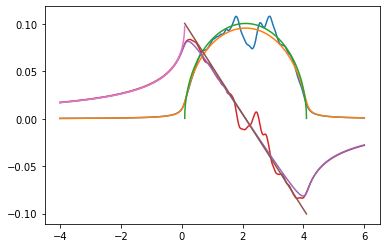

In [3]:
f = lambda z : tau*( -1.0*(z-tau) +1 + ell + np.sqrt( z-tau-lplus)*np.sqrt( z-tau-lminus))/2.0

ell = float(d)/n1
lplus = (1+np.sqrt(ell))**2
lminus = (1-np.sqrt(ell))**2
specx = np.linspace(lminus + tau + 0.00001,lplus + tau -0.00001,num=5000)

truev = lambda z : tau*(np.sqrt( lplus- z + tau )*np.sqrt( z-tau-lminus))/2.0
trueu_sp  = lambda z : z-tau*( -1.0*(z-tau) +1 + ell)/2.0
trueu_nonsp = lambda z : z-tau*( -1.0*(z-tau) +1 + ell - np.sqrt( lplus-z+tau)*np.sqrt( lminus-z+tau))/2.0

mvals = f(zs)
plt.plot(xvals, np.imag(R))
plt.plot(xvals, np.imag(mvals))
plt.plot(specx, truev(specx))

plt.plot(xvals, np.real(R))
plt.plot(xvals, np.real(mvals))
plt.plot(specx, specx-trueu_sp(specx))
outx = xvals[xvals < lminus+tau - 0.001]
outu = trueu_nonsp(outx)
plt.plot(outx, outx-outu)


#sum(np.imag(mvals)*(4-0.001)/np.pi/1000) ##should be r

In the cell below, we'll generate the loss for the Marchenko-Pastur case.  Here we simply test the number of steps.  We can in the future remove the loop.

In [4]:
def picard_loss_2ll(specx, specu, specv, outx, outu, t_max, n_grid, steps=3):
  """Runs Picard iteration to approximate the loss.

  Parameters
  ----------
  specx : Tensor
      x-values inside the continuous spectra on which to evaluate
  specu : Tensor
      values of the u-part (real) of the spectral density inside the continuous spectra
  specv : Tensor
      values of the v-part (imaginary) of the spectral density inside the continuous spectra
  outx : Tensor
      x-values below the spectral window
  outu : Tensor
      values of the u-function (z-R) 
  t_max : float
      The number of epochs 
  n_grid : int
      The number of grid points
  steps : int
      The number of iterations to run

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the loss
  """

  t_grid = tf.linspace(0.0, t_max, n_grid)
  t_grid = tf.cast(t_grid, dtype=tf.float64)

#  danger =  tf.reduce_max(I).numpy() 
#  if danger > 0.001:
#    print("Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is " + str(danger))
      
  
  #tf.reduce_sum()
  #knorm = tf.reduce_sum(I).numpy()
  #print( "kernel norm computed as "+str(knorm))

  loops = steps #int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  sol = tf.ones_like(t_grid,dtype=tf.float64)
  Dt = t_max/n_grid
  specDx = (specx[1]-specx[0]).numpy()
  outDx =(outx[1]-outx[0]).numpy()
  #init = specDx*tf.reduce_sum(-1.0*v/( (u)**2 + v**2 ))/(6.283185)

  #sol will represent the antiderivative of L.
  sol = tf.zeros_like(t_grid,dtype=tf.float64)

  for i in range(loops):
    #Uncomment this to display an iterate
    #print( "norm of iterate = {}".format(tf.linalg.norm(sol)))
    #generate the reciprocal of q
    invq = tf.math.exp(tf.math.cumsum(-4.0*sol*Dt))
    #this carries e^{2tx}/q(t) as an outer product (x,t), for the spectral x
    speceigtimes = tf.tensordot(2.0*specx,t_grid,axes=0)
    speceigtimes = tf.einsum('ij,j->ij', tf.math.exp(speceigtimes),invq)
    speceigtimes_twou = tf.einsum('i,ij->ij', 2*Dt*specu,speceigtimes)
    speceigtimes_twov = tf.einsum('i,ij->ij', 2*Dt*specv,speceigtimes)
    spectwoH_real = tf.math.cumsum(speceigtimes_twou,axis=1)
    spectwoH_imag = tf.math.cumsum(speceigtimes_twov,axis=1)
    #these carry twice the integral in t of H, in the real part and the imaginary part

    #this carries u(x)e^{2tx}/q(t) as an outer product (x,t), for the non-spectral x
    outeigtimes = tf.tensordot(2.0*outx,t_grid,axes=0)
    outeigtimes = tf.einsum('i,ij,j->ij', 2*Dt*outu, tf.math.exp(outeigtimes),invq)
    outwoH = tf.math.cumsum(outeigtimes,axis=1)
    #this carries twice the integral in t of H, outside the continuous spectrum
    
    sol = (1.0/6.28315)*specDx*tf.reduce_sum( tf.math.atan2(spectwoH_imag,1+spectwoH_real), axis=0)
    sol += 1.000*outDx*tf.math.count_nonzero( outwoH < -1, dtype=tf.float64, axis=0)
  return t_grid, sol

In [5]:
def picard_loss_2ll_quad(specx, specu, specv, specxweights, t_max, n_grid, steps=3):
  """Runs Picard iteration to approximate the loss.

  Parameters
  ----------
  specx : Tensor
      x-values inside the continuous spectra on which to evaluate
  specu : Tensor
      values of the u-part (real) of the spectral density inside the continuous spectra
  specv : Tensor
      values of the v-part (imaginary) of the spectral density inside the continuous spectra
  specxweights : Tensor
      quadrature weights at the specx values
  t_max : float
      The number of epochs 
  n_grid : int
      The number of grid points
  steps : int
      The number of iterations to run

  Returns
  -------
  t_grid: numpy.array(float)
      the time steps used, which will discretize (0,t_max) into n_grid points
  sol: numpy.array(float)
      the values of the solution to the loss
  """

  t_grid = tf.linspace(0.0, t_max, n_grid)
  t_grid = tf.cast(t_grid, dtype=tf.float64)

#  danger =  tf.reduce_max(I).numpy() 
#  if danger > 0.001:
#    print("Danger Will Robinson.  You may have numerical accuracy problems with this bin size. Increase numer of grid points. Your kernel bin maximum is " + str(danger))
      
  
  #tf.reduce_sum()
  #knorm = tf.reduce_sum(I).numpy()
  #print( "kernel norm computed as "+str(knorm))

  loops = steps #int(np.ceil(np.log(0.0001)/np.log(knorm)))
  print( "will use "+str(loops)+" iterations")

  sol = tf.ones_like(t_grid,dtype=tf.float64)
  Dt = t_max/n_grid
  #specDx = (specx[1]-specx[0]).numpy()
  #outDx =(outx[1]-outx[0]).numpy()
  #init = specDx*tf.reduce_sum(-1.0*v/( (u)**2 + v**2 ))/(6.283185)

  #sol will represent the antiderivative of L.
  sol = tf.zeros_like(t_grid,dtype=tf.float64)

  for i in range(loops):
    #Uncomment this to display an iterate
    #print( "norm of iterate = {}".format(tf.linalg.norm(sol)))
    #generate the reciprocal of q
    invq = tf.math.exp(tf.math.cumsum(-4.0*sol*Dt))
    #this carries e^{2tx}/q(t) as an outer product (x,t), for the spectral x
    speceigtimes = tf.tensordot(2.0*specx,t_grid,axes=0)
    speceigtimes = tf.einsum('ij,j->ij', tf.math.exp(speceigtimes),invq)
    speceigtimes_twou = tf.einsum('i,ij->ij', 2*Dt*specu,speceigtimes)
    speceigtimes_twov = tf.einsum('i,ij->ij', 2*Dt*specv,speceigtimes)
    spectwoH_real = tf.math.cumsum(speceigtimes_twou,axis=1)
    spectwoH_imag = tf.math.cumsum(speceigtimes_twov,axis=1)
    #these carry twice the integral in t of H, in the real part and the imaginary part

    #this carries u(x)e^{2tx}/q(t) as an outer product (x,t), for the non-spectral x
    #outeigtimes = tf.tensordot(2.0*outx,t_grid,axes=0)
    #outeigtimes = tf.einsum('i,ij,j->ij', 2*Dt*outu, tf.math.exp(outeigtimes),invq)
    #outwoH = tf.math.cumsum(outeigtimes,axis=1)
    #this carries twice the integral in t of H, outside the continuous spectrum
    
    sol = (1.0/6.28315)*tf.einsum('i,ij->j', specxweights, tf.math.atan2(spectwoH_imag,1+spectwoH_real))
    #sol = (1.0/6.28315)*specDx*tf.reduce_sum( tf.math.atan2(spectwoH_imag,1+spectwoH_real), axis=0)
    #sol += 1.000*outDx*tf.math.count_nonzero( outwoH < -1, dtype=tf.float64, axis=0)
  return t_grid, sol

In [6]:
t_max = 2.0
n_grid = 1000
steps=10



specv = truev(specx)
specu = trueu_sp(specx)

tfspecx = tf.constant(specx)
tfspecv = truev(tfspecx)
tfspecu = trueu_sp(tfspecx)

tfoutx = tf.constant(outx)
tfoutu = tf.constant(outu)


tsa, lsa = picard_loss_2ll(tfspecx, tfspecu, tfspecv, 
                                        tfoutx, tfoutu,
                                        t_max, n_grid, steps=steps)
#ts =ts[1:]
#ls = (ls[1:]-ls[:-1])*t_max/n_grid

#totalsteps = 10
#els = []
#for j in range(1,totalsteps):
#  ts, ls = picard_loss_2ll(specx, specu, specv, t_max, n_grid, steps=j)

#els.append(np.copy(ls.numpy()))


will use 10 iterations


In [ ]:
t_max = 2.0
n_grid = 1000
nx_grid = 20000
steps=10


ell = float(d)/n1
lplus = (1+np.sqrt(ell))**2
lminus = (1-np.sqrt(ell))**2
#specx = np.linspace(lminus + tau + 0.00001,lplus + tau -0.00001,num=1000)
specx = np.cos(np.linspace(0, np.pi,num=nx_grid)+0.5/nx_grid)*(lplus-lminus)/2.0 + (lminus+lplus)/2.0 + tau
specxweights =np.sin(np.linspace(0, np.pi,num=nx_grid)+0.5/nx_grid)*(lplus-lminus)/2.0*np.pi/nx_grid

specv = truev(specx)
specu = trueu_sp(specx)

tfspecx = tf.constant(specx)
tfspecv = truev(tfspecx)
tfspecu = trueu_sp(tfspecx)
tfspecxweights = tf.constant(specxweights)

#tfoutx = tf.constant(outx)
#tfoutu = tf.constant(outu)


ts, ls = picard_loss_2ll_quad(tfspecx, tfspecu, tfspecv, tfspecxweights, 
                                        t_max, n_grid, steps=steps)

will use 10 iterations


The convergence appears extremely rapid..  We turn to generating the gradient flow loss.

In [ ]:
def tfs_gf_2ll( X, W1, W2, y, t_max, ridge=0.0, 
               loss= lambda X,W1,W2,y : tf.reduce_sum((tf.einsum('ij,jk,k',X,W1,W2)-y)**2), 
               batchsize=100, gamma=-1, oversample=10):
  """Generates gradient flow loss of linear 2-layer network.  Batch provided.

  Parameters
  ----------
  X : data matrix, n x d
      The data
  W1 : weight matrix, d x n1
      The feature matrix
  W2 : weight matrix, n1 x 1
      The final layer
  y : target vector, n x 1
      The target    
  t_max : float
      How long to run gradient flow time
  ridge : float, optional
      UNUSED The strength of the ridge regularization (per iteration)
  loss : vector-input function, optional
      The loss to compute at each epoch.  Defaults to the empirical loss.
  batchsize : int
      The size of the batch, defaults to 100.
  gamma: float, optional
      (Additional gradient) stepsize parameter, defaults to n/||A||**2, with
      Frobenius norm ||A||. Pass 'adaptive' for adaptive scheme.
  ridge: float, optional
      The ridge parameter to pass.
  oversample: int, optional
      return additional losses, by a multiple of oversample 
      (note integer division is performed, so every d//oversample is returned).
      Pass 'adaptive' for exponentially spaced samples.
  

  Returns
  -------
  W1 : weight matrix, d x n1
      The feature matrix
  W2 : weight matrix, n1 x 1
      The final layer
  losses : numpy.array(float)
      an array of floats that are the losses of the least squares problem, one
      per epoch
  times: numpy.array(int)
      the iteration counts at which the sgd was sampled
  """

  (n,d) = X.shape
  (d,n1) = W1.shape
  mb = batchsize
  print("Working with batch={}, d={}".format(mb,d))
  adaptivesample=False
  #TL = lambda x: (1/2)*np.sum( (A@x-b)**2)
  
  losses = []
  times = []

  Xb = tf.split(X, n//mb,axis=0)
  yb = tf.split(y, n//mb)
  H = zip(Xb,yb)

  if( gamma == -1):
    gamma = 1/tf.linalg.norm(W1)**2
  steps = int( t_max/gamma)
  print("Computed gamma={} and running steps={} iterations".format(gamma,steps))


  #GR = lambda A,x,b,ridge : A * (A.dot(x) - b) + ridge*x
  #GR = lambda A,x,b,ridge : A[0] * (tf.tensordot(A,x,axes=[1,0]) - b) + ridge*x
  #GR = lambda a,x,b,ridge : gamma*(tf.einsum('ji,jk,k',a,a,x)-tf.einsum('ji,j',a,b)+(ridge*minibatch)*x)


  for t in range(steps):
    H = zip(Xb,yb)
    for (x,yc) in H:
      Delta = tf.einsum('ij,jk,k',x,W1,W2) - yc
      #XDelta = tf.transpose(x)@Delta
      XDelta = tf.einsum('ij,i',x,Delta)
      W2 -= gamma*tf.einsum('ij,i',W1,XDelta)# tf.transpose(W1)@XDelta
      W1 -= gamma*tf.tensordot(XDelta, W2,axes=0)
    
    if t % (oversample) == 0:
      l = loss(X,W1,W2,y)
      tz= t*gamma
      #print("Loss is currently = {} at time = {}".format(l,tz))
      losses.append(l)
      times.append(t*gamma)

  return W1,W2, np.array(losses), times

In [ ]:
n1 = 40*16
d = 30*16
n = 30*16
t_max = 2.0
runs = 16

lse_runs =[]
for i in range(runs):
  X = tf.eye(n)
  W1 = tf.random.normal([d,n1])
  W1 = W1/np.sqrt(n1)
  W2 = tf.random.normal([n1])/np.sqrt(10*n1)

  Wout1,Wout2, lse, tse = tfs_gf_2ll( X, W1, W2, tf.zeros([n]), t_max, gamma=0.002, ridge=0.0, batchsize=160, oversample=1)
  lse_runs.append(np.cumsum(lse)*(tse[1]-tse[0]))

plt.plot(tse,np.cumsum(lse)*(tse[1]-tse[0]))
plt.plot(ts,ls)
#for j in range(totalsteps-2):
#  plt.plot(ts,els[j])
plt.yscale('log')

In [ ]:
for i in range(runs):
  plt.plot(tse,lse_runs[i],c=plt.cm.plasma(0.9))
plt.plot(ts,ls,c=plt.cm.plasma(0.1))
#plt.plot(tsa,lsa,c=plt.cm.plasma(0.1))
#for j in range(totalsteps-2):
#  plt.plot(ts,els[j])
#plt.yscale('log')

In [ ]:
for i in range(runs):
  plt.plot(tse[:-1],np.diff(lse_runs[i])/(tse[1]-tse[0]),c=plt.cm.plasma(0.9))
plt.plot(ts[:-1],np.diff(ls)/(ts[1]-ts[0]),c=plt.cm.plasma(0.1))
#plt.plot(tsa[:-1],np.diff(lsa)/(tsa[1]-tsa[0]),c=plt.cm.plasma(0.1))
plt.yscale('log')